In [12]:
using PyPlot
using Optim

# Experiment 2: Simulate Huber Noise

## Load Data

In [2]:
m,n = 20480, 202;  # size of matrix
mp, np = 128,160;   # size of one image

(128,160)

In [3]:
fid = open("results/R.bin","r")
Rt  = read(fid,Float64,m*n)
close(fid)
R = copy(Rt);

## Add Small Scale Gaussian Noise

In [4]:
R = R + 0.1*randn(m*n);

## Maximum Likelihood
* Penalty:
$$ \rho(r;[\kappa,\sigma]) =
\begin{cases}
\kappa|r|/\sigma - \kappa^2/2 ,&|r| > \kappa\sigma\\
r^2/(2\sigma^2) ,&|r|\le\kappa\sigma
\end{cases}
$$
* Density:
$$p(r;[\kappa,\sigma]) = \exp[-\rho(r;[\kappa,\sigma])]/n_c([\kappa,\sigma])$$
* Normalization constant:
$$n_c([\kappa,\sigma]) = \sigma\left[\frac{2\exp(-\kappa^2/2)}{\kappa} + \sqrt{2\pi}\,\text{erf}\left(\frac{\kappa}{\sqrt{2}}\right)\right]$$
* Maximum likelihood:
$$ \min_{\kappa,\sigma} \frac{1}{mn}\sum_{i,j}\rho(R_{ij};[\kappa,\sigma]) + \log[n_c([\kappa,\sigma])]$$

In [4]:
function objθ(θ,R)
    κ = θ[1];
    σ = θ[2];
    κtσ = κ*σ;
    κdσ = κ/σ;
    n = length(R);
    val = 0.0;
    for i = 1:n
        val += ifelse(abs(R[i])>κtσ,κdσ*abs(R[i])-0.5*κ^2,0.5*R[i]^2/σ^2)
    end
    val /= n
    c = σ*(2.0*exp(-0.5*κ^2)/κ + sqrt(2*pi)*erf(κ/sqrt(2)));
    val += log(c)
    return val
end

objθ (generic function with 1 method)

In [5]:
function gradHθ(θ,R)
    n   = length(R)
    κ,σ = θ[1],θ[2]
    # gradient and hessian of huber penalty w.r.t. κ
    g   = zeros(2)
    H   = zeros(2,2)
    for I in eachindex(R)
        if abs(R[I]) > κ*σ
            # gradient
            g[1] += abs(R[I])/σ - κ
            g[2] -= κ*abs(R[I])/σ^2
            # hessian
            H[1,1] -= 1.0
            H[1,2] -= abs(R[I])/σ^2
            H[2,1] -= abs(R[I])/σ^2
            H[2,2] += 2.0*κ*abs(R[I])/σ^3
        else
            # gradient
            g[2] -= R[I]^2/σ^3
            # hessian
            H[2,2] += 3*R[I]^2/σ^4
        end
    end
    scale!(g,1/n)
    scale!(H,1/n)
    # gradient and hessian of log normalization constant
    eκ  = exp(-0.5*κ^2)
    c   = 2.0*eκ/κ + sqrt(2.0*pi)*erf(κ/sqrt(2.0))
    dc  = -2.0*eκ/κ^2
    ddc = (4.0/κ^3+2.0/κ)*eκ
    g[1] += dc/c
    g[2] += 1.0/σ
    H[1,1] += (ddc*c - dc^2)/c^2
    H[2,2] -= 1.0/σ^2

    return g, H
end

gradHθ (generic function with 1 method)

In [14]:
# res = optimize(θ->obj(θ,R),[1.0,1.0],GradientDescent())
# Newton's method
tol = 1e-6;
itm = 50;
θ   = [1.5,0.06];
g,H = gradHθ(θ,R);
err = vecnorm(g);
noi = 0;
while err ≥ tol
    # update direction
    a,b = eig(H)
    @show(a)
    noi ≥ 10 ? p = H \ g : p = g/norm(H);
    # line search
    η = 1.0;
    p[1] > θ[1] && (η = min(η,θ[1]/p[1]*0.99));
    p[2] > θ[2] && (η = min(η,θ[2]/p[2]*0.99));
    # update θ
    θ = θ - η*p;
    # update history
    g,H = gradHθ(θ,R);
    obj = objθ(θ,R);
    err = vecnorm(g);
    noi = noi + 1;
    noi%1==0 && @printf("iter %3d, obj %1.5e, err %1.5e\n",noi,obj,err)
    if noi ≥ itm
        break;
    end
end

a = [0.0271159,242.124]
iter   1, obj -1.35706e+00, err 2.68428e+00
a = [-0.0896463,723.269]
iter   2, obj -1.36253e+00, err 3.87607e-01
a = [-0.0505958,533.49]
iter   3, obj -1.36268e+00, err 1.09015e-01
a = [-0.0440468,504.443]
iter   4, obj -1.36270e+00, err 1.08541e-01
a = [-0.0438433,503.672]
iter   5, obj -1.36273e+00, err 1.08550e-01
a = [-0.0438091,503.729]
iter   6, obj -1.36275e+00, err 1.08560e-01
a = [-0.0437864,503.782]
iter   7, obj -1.36277e+00, err 1.08569e-01
a = [-0.043763,503.836]
iter   8, obj -1.36280e+00, err 1.08579e-01
a = [-0.0437361,503.891]
iter   9, obj -1.36282e+00, err 1.08588e-01
a = [-0.0436993,503.949]
iter  10, obj -1.36284e+00, err 1.08598e-01
a = [-0.0436764,504.003]
iter  11, obj -1.15158e+00, err 4.97681e+00
a = [-0.00232234,54.1268]
iter  12, obj 5.77176e+00, err 9.38232e+02
a = [-0.0772937,1.58799e5]
iter  13, obj 2.16742e+00, err 3.87621e+02
a = [-0.0388583,51696.6]
iter  14, obj 2.90608e-01, err 1.57474e+02
a = [-0.0199846,17212.8]
iter  15, ob

## Plot Result

In [8]:
function eCDF(x::Array{Float64,1},R::Array{Float64,1})
    sort!(x)
    n = length(x)
    m = length(R)
    v = zeros(n)
    j = 1
    for i = 1:n
        while j ≤ m && R[j] < x[i]
            j += 1
        end
        v[i] = (j-1)/m
    end
    return v
end

eCDF (generic function with 1 method)

In [9]:
include("codes/utility.jl")
function κCDF(x::Array{Float64,1},κ,σ) # with variance
    sort!(x)
    n = length(x)
    v = zeros(n)
    c = 2.0*exp(-0.5*κ^2)/κ + sqrt(2.0*pi)*erf(κ/sqrt(2));
    for i = 1:n
        v[i] = cdfH(x[i]/σ,κ,c)
    end
    return v
end

κCDF (generic function with 1 method)

In [12]:
x = collect(linspace(-0.5,0.5,100));
sort!(R);
v1 = eCDF(x,R);
v2 = κCDF(x,θ[1],θ[2]);
# v2 = κCDF(x,1.5,0.06);

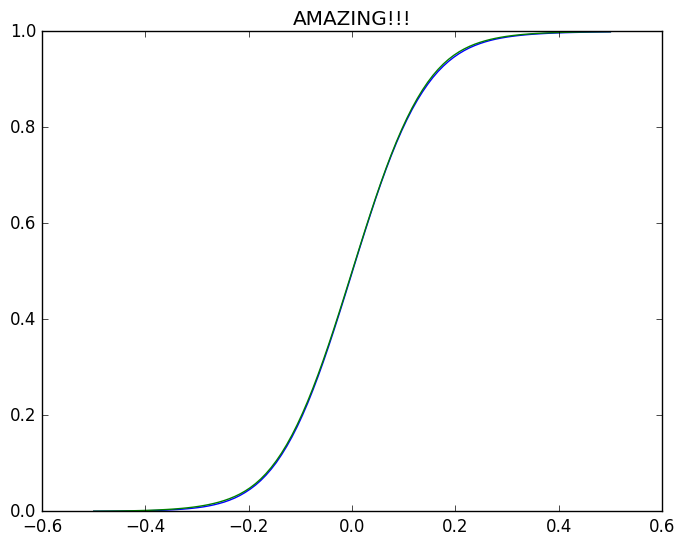

PyObject <matplotlib.text.Text object at 0x325f7f210>

In [13]:
plot(x,v1,"b")
plot(x,v2,"g")
title("AMAZING!!!")

## Recover S

In [14]:
κσ = θ[1]*θ[2];
S  = zeros(m,n);
r  = reshape(Rt,m,n);
for I in eachindex(S)
    r[I] >  κσ ? S[I] = r[I] - κσ :
    r[I] < -κσ ? S[I] = r[I] + κσ : continue;
end

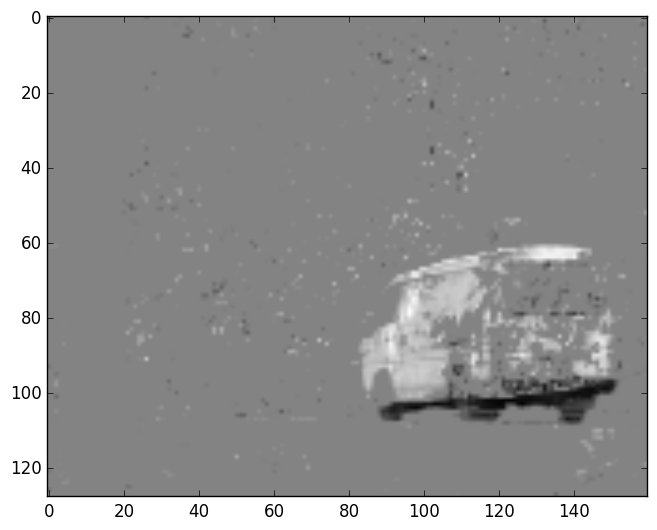

In [15]:
imshow(reshape(S[:,201],mp,np), cmap="gray");